In [83]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools

In [84]:
# Load the dataset
sales_data = pd.read_csv("sales.csv")

In [85]:
# Check the data if all columns are numbers
sales_data.dtypes

Unnamed: 0              int64
store_ID                int64
day_of_week             int64
date                   object
nb_customers_on_day     int64
open                    int64
promotion               int64
state_holiday          object
school_holiday          int64
sales                   int64
dtype: object

In [86]:
# Check no missing values
sales_data.isnull().sum()

Unnamed: 0             0
store_ID               0
day_of_week            0
date                   0
nb_customers_on_day    0
open                   0
promotion              0
state_holiday          0
school_holiday         0
sales                  0
dtype: int64

In [87]:
# Print dataframe head to inspect data
sales_data.head()

,Unnamed: 0,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,425390,366,4,2013-04-18,517,1,0,0,0,4422
1,291687,394,6,2015-04-11,694,1,0,0,0,8297
2,411278,807,4,2013-08-29,970,1,1,0,0,9729
3,664714,802,2,2013-05-28,473,1,1,0,0,6513
4,540835,726,4,2013-10-10,1068,1,1,0,0,10882


In [88]:
# Rename unnamed first column
sales_data.rename(columns={'Unnamed: 0':'something'}, inplace=True)
sales_data.head()

,something,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,425390,366,4,2013-04-18,517,1,0,0,0,4422
1,291687,394,6,2015-04-11,694,1,0,0,0,8297
2,411278,807,4,2013-08-29,970,1,1,0,0,9729
3,664714,802,2,2013-05-28,473,1,1,0,0,6513
4,540835,726,4,2013-10-10,1068,1,1,0,0,10882


In [89]:
# Seperate date column into month, day and year to account for seasonal and annual fluctuations in sales 
sales_data['date'] = pd.to_datetime(sales_data['date'])
sales_data['year'] = sales_data['date'].dt.year
sales_data['month'] = sales_data['date'].dt.month
sales_data['day'] = sales_data['date'].dt.day

# Drop date column as this is not informative to the model
sales_data.drop(["date"], axis = "columns", inplace=True)
sales_data.head()


,something,store_ID,day_of_week,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales,year,month,day
0,425390,366,4,517,1,0,0,0,4422,2013,4,18
1,291687,394,6,694,1,0,0,0,8297,2015,4,11
2,411278,807,4,970,1,1,0,0,9729,2013,8,29
3,664714,802,2,473,1,1,0,0,6513,2013,5,28
4,540835,726,4,1068,1,1,0,0,10882,2013,10,10


In [90]:
# Handling with categorical variables, etc.
sales_data['state_holiday'].value_counts()

state_holiday
0    621160
a     12842
b      4214
c      2624
Name: count, dtype: int64

In [91]:
# Apply label encoding to 'state_holiday' column
sales_data['state_holiday'] = LabelEncoder().fit_transform(sales_data['state_holiday'])

# Check of the State holiday has been replaced correctly
sales_data['state_holiday'].value_counts()

state_holiday
0    621160
1     12842
2      4214
3      2624
Name: count, dtype: int64

In [92]:
scaler = MinMaxScaler()
# Select the continuous columns to scale
columns_to_scale = ['nb_customers_on_day', 'promotion']

# Apply MinMax scaling to the selected columns
sales_data[columns_to_scale] = scaler.fit_transform(sales_data[columns_to_scale])

# Display the first few rows to verify scaling
sales_data[columns_to_scale].head()

,nb_customers_on_day,promotion
0,0.094723,0.0
1,0.127153,0.0
2,0.177721,1.0
3,0.086662,1.0
4,0.195676,1.0


In [93]:
# Set plot style
plt.style.use('ggplot')

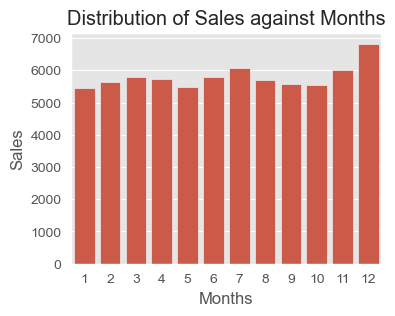

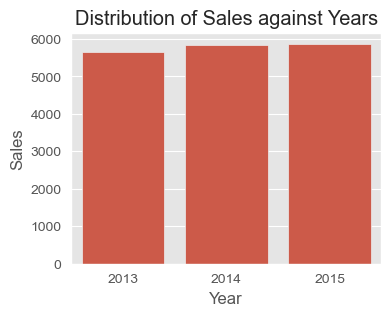

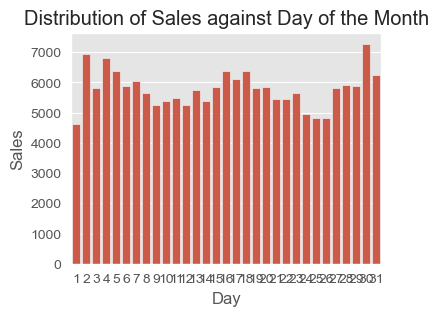

In [94]:
# Analyze the distribution of the 'sales' variable against the months of the year
plt.figure(figsize=(4, 3))
sns.barplot(x="month", y="sales", data=sales_data, errorbar=None)
plt.title('Distribution of Sales against Months')
plt.xlabel('Months')
plt.ylabel('Sales')
plt.show()

# Analyze the distribution of the 'sales' variable against the years
plt.figure(figsize=(4, 3))
sns.barplot(x="year", y="sales", data=sales_data, errorbar=None)
plt.title('Distribution of Sales against Years')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.show()

# Analyze the distribution of the 'sales' variable against thedays of the month
plt.figure(figsize=(4, 3))
sns.barplot(x="day", y="sales", data=sales_data, errorbar=None)
plt.title('Distribution of Sales against Day of the Month')
plt.xlabel('Day')
plt.ylabel('Sales')
plt.show()

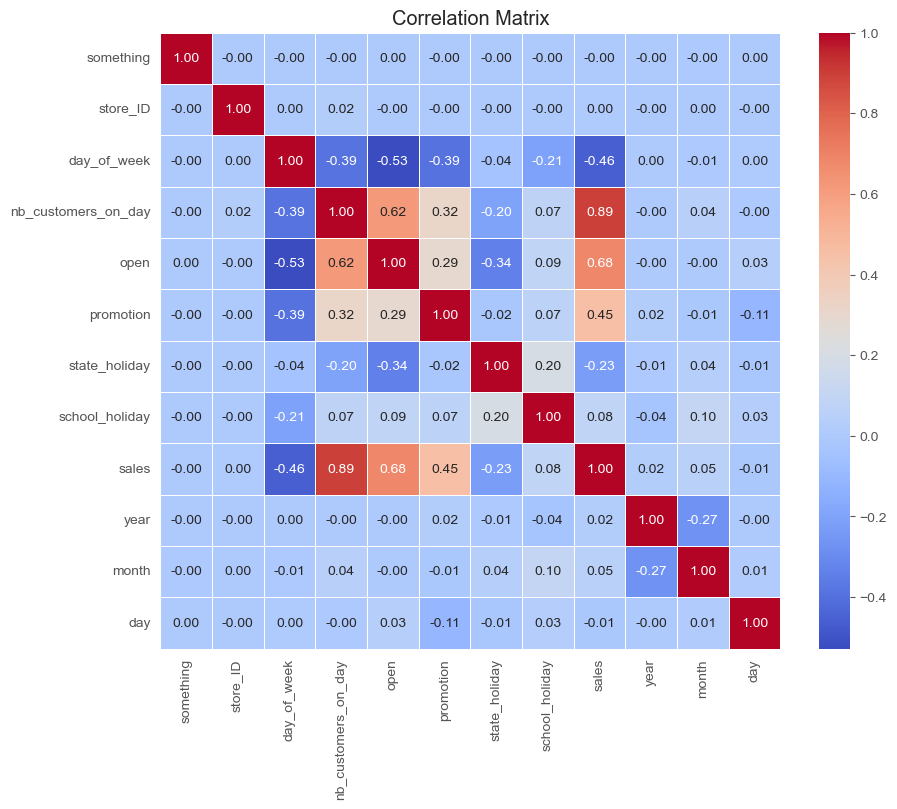

In [95]:
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = sales_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [96]:
calculate_best = False

if calculate_best:
  # Define empty array and variable for best model features and R2
  best = []
  best_R2 = 0
  
  # Defining x, y to initialize model
  X = sales_data.drop(columns=['sales'])
  y = sales_data['sales']
  
  # Loop through all combinations of columns with an xgboost algorithm to find the best model
  columns = X.columns
  
  def evaluate_model(feature_combination):
      X_subset = X[list(feature_combination)]
  
      # Step 1: Split data set into training and test data
      X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42)
      
      # Step 2: Initialize model
      model = XGBRegressor()
  
      # Step 3: Train the model
      model.fit(X_train, y_train)
          
      # Step 4: Predict on test data
      y_pred = model.predict(X_test)
          
      # Step 5: Calculate metrics
      r2 = r2_score(y_test, y_pred)
      return r2 
      
  # Print performance metrics and best model combination as well as R2 score
  for r in range(1, len(columns) + 1):
      for combo in itertools.combinations(columns, r):
          r2 = evaluate_model(combo)
          if r2 > best_R2:
              best = combo
              best_R2 = r2
              print(combo)
              print(f"R²: {r2:.4f}")
  print(best, best_R2)

In [97]:
data_to_predict = pd.read_csv('G3.csv')

# Check no missing values
data_to_predict.isnull().sum()

index                  0
store_ID               0
day_of_week            0
date                   0
nb_customers_on_day    0
open                   0
promotion              0
state_holiday          0
school_holiday         0
dtype: int64

In [98]:
# Print dataframe head to inspect data
data_to_predict.head()

,index,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday
0,272371,415,7,01/03/2015,0,0,0,0,0
1,558468,27,7,29/12/2013,0,0,0,0,0
2,76950,404,3,19/03/2014,657,1,1,0,0
3,77556,683,2,29/01/2013,862,1,0,0,0
4,456344,920,3,19/03/2014,591,1,1,0,0


In [99]:
# Seperate date column into month, day and year to account for seasonal and annual fluctuations in sales 
data_to_predict['date'] = pd.to_datetime(data_to_predict['date'], format='%d/%m/%Y')

data_to_predict['year'] = data_to_predict['date'].dt.year
data_to_predict['month'] = data_to_predict['date'].dt.month
data_to_predict['day'] = data_to_predict['date'].dt.day

# Drop date column as this is not informative to the model
data_to_predict.drop(["date"], axis="columns", inplace=True)
data_to_predict.head()

,index,store_ID,day_of_week,nb_customers_on_day,open,promotion,state_holiday,school_holiday,year,month,day
0,272371,415,7,0,0,0,0,0,2015,3,1
1,558468,27,7,0,0,0,0,0,2013,12,29
2,76950,404,3,657,1,1,0,0,2014,3,19
3,77556,683,2,862,1,0,0,0,2013,1,29
4,456344,920,3,591,1,1,0,0,2014,3,19


In [100]:
# Handling with categorical variables, etc.
data_to_predict['state_holiday'].value_counts()

state_holiday
0    69050
a     1405
b      475
c      275
Name: count, dtype: int64

In [101]:
# Apply label encoding to 'state_holiday' column
data_to_predict['state_holiday'] = LabelEncoder().fit_transform(data_to_predict['state_holiday'])

# Check of the State holiday has been replaced correctly
data_to_predict['state_holiday'].value_counts()

state_holiday
0    69050
1     1405
2      475
3      275
Name: count, dtype: int64

In [102]:
best_columns = ['store_ID', 'day_of_week', 'nb_customers_on_day', 'promotion', 'year', 'month', 'day']

X = sales_data[best_columns]
y = sales_data['sales']

X_pred = data_to_predict[best_columns]

# Step 1: Split data set into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Initialize model
model = XGBRegressor()

# Step 3: Train the model
model.fit(X_train, y_train)
    
# Step 4: Predict on test data
y_pred = model.predict(X_pred)

In [113]:
y_pred = np.where(y_pred < 0, 0, y_pred)
data_to_predict["y_pred"] = y_pred.astype(int)

data_to_predict.to_csv('G2_done.csv', index=False)

## Models tested:

1. Linear Regression - R²: 0.85, RMSE: 0.04, MAE: 0.02

2. Descision Tree

    a) Descision Tree Depth 3 - R²: 0.81, RMSE: 0.04, MAE: 0.03

    b) Descision Tree Depth 5 - R²: 0.86, RMSE: 0.04, MAE: 0.02

    c) Descision Tree Depth 7 - R²: 0.87, RMSE: 0.03, MAE: 0.02

    d) Descision Tree Depth 8 - R²: 0.87, RMSE: 0.03, MAE: 0.02

    e) Descision Tree Depth 9 - R²: 0.88, RMSE: 0.03, MAE: 0.02

    f) Descision Tree Depth 10 - R²: 0.88, RMSE: 0.03, MAE: 0.02

3. Random Forest - Performance not better than Descision Tree

4. Gradient Boosting 

    a) Gradient Boosting Depth 3 - R²: 0.88, RMSE: 0.03, MAE: 0.02

    b) Gradient Boosting Depth 5 - R²: 0.88, RMSE: 0.03, MAE: 0.02

    c) Gradient Boosting Depth 7 - R²: 0.88, RMSE: 0.03, MAE: 0.02
    
5. XGBoost 

    a) XGBoost default - R²: 0.88, RMSE: 0.03, MAE: 0.02 

    b) XGBoost linear - R²: 0.85, RMSE: 0.04, MAE: 0.02 

    c) XGBoost dart - R²: 0.88, RMSE: 0.03, MAE: 0.02 
   
    d) XGBoost default - R²: 0.93, RMSE: 0.03, MAE: 0.02 (with selected columns)

6. K-Nearest Neighbours

    #Sample size: half of the original data

    a) KNN 3 Neighbours - R²: 0.84, RMSE: 0.04, MAE: 0.02 - half

    b) KNN 5 Neighbours - R²: 0.86, RMSE: 0.03, MAE: 0.02 - half

    c) KNN 10 Neighbours - R²: 0.87, RMSE: 0.03, MAE: 0.02 - half

    #Sample size: full data set
    
    d) KNN 15 - R²: 0.87, RMSE: 0.03, MAE: 0.02 - full

7. svm - takes too long

We also checked for feature importance and dropped unimportant columns ("month", "school_holiday", "state_holiday", "open"), but results were worse than on the full model